**Upload dataset from Kaggle to Colab**

In [ ]:
! pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"anshanxb","key":"9fe9fb0b970606ce28848cf8464632ae"}'}

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download muhammetzahitaydn/hardhat-vest-dataset-v3

Dataset URL: https://www.kaggle.com/datasets/muhammetzahitaydn/hardhat-vest-dataset-v3
License(s): CC0-1.0
100% 4.21G/4.21G [03:54<00:00, 20.8MB/s]
100% 4.21G/4.21G [03:54<00:00, 19.3MB/s]


In [ ]:
!unzip -q hardhat-vest-dataset-v3.zip -d ./dataset

In [ ]:
# Create new directories for train, test, and val that will hold both images and labels
!mkdir -p dataset/train/images
!mkdir -p dataset/train/labels
!mkdir -p dataset/test/images
!mkdir -p dataset/test/labels
!mkdir -p dataset/val/images
!mkdir -p dataset/val/labels

In [ ]:
# Move the images and labels into the new train, test, and val directories
# Move train data
!mv dataset/images/train/* dataset/train/images/
!mv dataset/labels/train/* dataset/train/labels/

# Move test data
!mv dataset/images/test/* dataset/test/images/
!mv dataset/labels/test/* dataset/test/labels/

# Move val data
!mv dataset/images/val/* dataset/val/images/
!mv dataset/labels/val/* dataset/val/labels/

In [ ]:
# Check the structure of the train, test, and val directories
!ls dataset/train
!ls dataset/test
!ls dataset/val

images	labels
images	labels
images	labels


In [ ]:
# Remove the original images and labels folders
!rm -rf dataset/images
!rm -rf dataset/labels

In [ ]:
# Check the structure of the dataset
!ls dataset/

test  train  val


**Object Detection**

In [ ]:
# install ultralytics
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 881.3/881.3 kB 48.1 MB/s eta 0:00:00


In [ ]:
# import necessary libraries
import os
import pandas as pd
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO
import yaml
import seaborn as sns
from PIL import Image
import glob
import shutil
import scipy.optimize

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
# path of dataset
dataset_path = '/content/dataset'

In [ ]:
# create yaml file

num_classes = 3
classes = ['helmet', 'vest', 'head']

yaml_file = {'train' : os.path.join(dataset_path, 'train'),
             'test' : os.path.join(dataset_path, 'test'),
             'val' : os.path.join(dataset_path, 'val'),
             'nc' : num_classes,
             'names' : classes}

with open(os.path.join(dataset_path, 'data.yaml'), 'w') as f:
  yaml.dump(yaml_file, f)

In [ ]:
# class distributions

# Set class indices
class_indices = {
    'helmet': 0,
    'vest': 1,
    'head': 2
}

num_classes = len(class_indices)
class_count = {}
labels_count = {}

for dataset_type in ['train', 'test', 'val']:
    # Initialize class count for each class in the current dataset (train/val)
    class_count_for_each_class = {}
    for class_name in class_indices:
        class_count_for_each_class[class_name] = 0

    # Path to the labels folder for current dataset (train/val)
    path = os.path.join(dataset_path, dataset_type, 'labels')

    # Iterate through each label file in the folder
    for file in os.listdir(path):
        if file.endswith('.txt'):
            with open(os.path.join(path, file), 'r') as f:
                lines = f.readlines()
                for line in lines:
                    # Get the class index from the annotation line
                    class_index = int(line.split()[0])
                    class_name = list(class_indices.keys())[class_index]
                    # Increment the class count
                    class_count_for_each_class[class_name] += 1

    # Store the class count and labels_count
    class_count[dataset_type] = class_count_for_each_class
    labels_count[dataset_type] = len(os.listdir(path))

# Output the class statistics and data length
print("Class Count: ", class_count)
print("Labels Count: ", labels_count)


Class Count:  {'train': {'helmet': 43905, 'vest': 6326, 'head': 98256}, 'test': {'helmet': 6749, 'vest': 935, 'head': 12509}, 'val': {'helmet': 6586, 'vest': 870, 'head': 13576}}
Labels Count:  {'train': 17248, 'test': 2455, 'val': 2438}


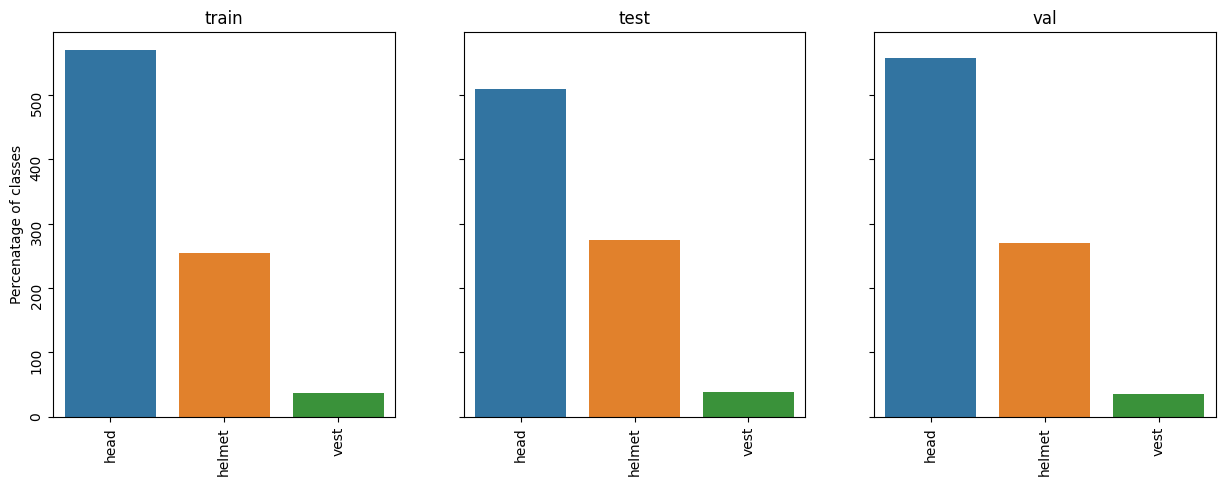

In [ ]:
# plotting of class distributions
fig, ax = plt.subplots(1,3, figsize=(15, 5), sharey=True)

for i, dataset_type in enumerate(['train', 'test', 'val']):
    sns.barplot(pd.DataFrame({dataset_type:class_count[dataset_type]}).T/labels_count[dataset_type]*100, ax=ax[i])
    ax[i].set_title(dataset_type)
    ax[i].tick_params(rotation=90)
    ax[i].set_ylabel('Percenatage of classes')
plt.show()

In [ ]:
# check size of images

for dataset_type in ['train', 'test', 'val']:
    print(f'\nImage sizes in {dataset_type } set:\n')
    img_size = 0
    for file in glob.glob(os.path.join(dataset_path, dataset_type , 'images', '*')):
        image = Image.open(file)
        if image.size != img_size:
            print(f'\t{image.size}')
            img_size = image.size


Image sizes in train set:

	(640, 640)

Image sizes in test set:

	(640, 640)

Image sizes in val set:

	(640, 640)


In [ ]:
# load model
model = YOLO('yolov8n.pt')

100%|██████████| 6.25M/6.25M [00:00<00:00, 339MB/s]


In [ ]:
# train model
model.train(data='/content/dataset/data.yaml',
            task='detect',
            imgsz=640,
            epochs=10,
            batch=32,
            mode='train',
            project='/content/saved_models',
            name='yolov8n_v1_train')

Ultralytics 8.3.0 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/dataset/data.yaml, epochs=10, time=None, patience=100, batch=32, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=/content/saved_models, name=yolov8n_v1_train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True,

100%|██████████| 755k/755k [00:00<00:00, 25.8MB/s]


Overriding model.yaml nc=80 with nc=3

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

train: Scanning /content/dataset/train/labels... 17248 images, 10 backgrounds, 0 corrupt: 100%|██████████| 17248/17248 [00:26<00:00, 640.65it/s] 


train: New cache created: /content/dataset/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.16 (you have 1.4.15). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning /content/dataset/val/labels... 2438 images, 1 backgrounds, 0 corrupt: 100%|██████████| 2438/2438 [00:03<00:00, 661.85it/s]

val: New cache created: /content/dataset/val/labels.cache


Plotting labels to /content/saved_models/yolov8n_v1_train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 63 weight(decay=0.0), 70 weight(decay=0.0005), 69 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to /content/saved_models/yolov8n_v1_train
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      10.8G       1.65      1.713       1.23        241        640: 100%|██████████| 539/539 [06:08<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:31<00:00,  1.25it/s]


                   all       2438      21032      0.759      0.653       0.71      0.369

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      9.54G      1.585      1.046      1.207        363        640: 100%|██████████| 539/539 [06:03<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:30<00:00,  1.29it/s]


                   all       2438      21032      0.784      0.706      0.761      0.413

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      11.5G      1.552     0.9225      1.184        168        640: 100%|██████████| 539/539 [05:48<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:28<00:00,  1.38it/s]


                   all       2438      21032       0.77      0.684      0.741      0.386

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      11.1G      1.536     0.8688      1.176        290        640: 100%|██████████| 539/539 [05:44<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:29<00:00,  1.33it/s]


                   all       2438      21032       0.83      0.729      0.805       0.45

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      10.1G      1.503     0.8133      1.155        248        640: 100%|██████████| 539/539 [05:52<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:28<00:00,  1.38it/s]


                   all       2438      21032      0.812      0.744      0.797      0.449

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      11.3G       1.48     0.7786      1.141        288        640: 100%|██████████| 539/539 [05:50<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:28<00:00,  1.39it/s]


                   all       2438      21032      0.825      0.775      0.827      0.486

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      9.93G      1.455      0.746      1.131        309        640: 100%|██████████| 539/539 [05:54<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:29<00:00,  1.30it/s]


                   all       2438      21032      0.845      0.793      0.846      0.504

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      9.73G      1.435     0.7158      1.121        378        640: 100%|██████████| 539/539 [05:55<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:29<00:00,  1.31it/s]


                   all       2438      21032      0.843      0.809      0.852      0.511

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      12.3G      1.414     0.6907      1.109        192        640: 100%|██████████| 539/539 [05:50<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:27<00:00,  1.40it/s]


                   all       2438      21032      0.853      0.812      0.861      0.521

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10        11G      1.394     0.6684      1.099        239        640: 100%|██████████| 539/539 [05:47<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:29<00:00,  1.31it/s]


                   all       2438      21032      0.858      0.816      0.866      0.529

10 epochs completed in 1.070 hours.
Optimizer stripped from /content/saved_models/yolov8n_v1_train/weights/last.pt, 5.6MB
Optimizer stripped from /content/saved_models/yolov8n_v1_train/weights/best.pt, 5.6MB

Validating /content/saved_models/yolov8n_v1_train/weights/best.pt...
Ultralytics 8.3.0 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 186 layers, 2,684,953 parameters, 0 gradients, 6.8 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:35<00:00,  1.09it/s]


                   all       2438      21032      0.859      0.816      0.866      0.529
                helmet       1782       6586      0.918      0.852      0.907      0.591
                  vest        406        870      0.791      0.739      0.814      0.531
                  head        712      13576      0.868      0.857      0.877      0.465
Speed: 0.2ms preprocess, 2.3ms inference, 0.0ms loss, 2.4ms postprocess per image
Results saved to /content/saved_models/yolov8n_v1_train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7edebe94e8f0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04

In [ ]:
# mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# validation

model = YOLO('/content/drive/MyDrive/best.pt')
results = model.val(data='/content/dataset/data.yaml', iou=0.5)
print(results)

Ultralytics 8.3.0 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 186 layers, 2,684,953 parameters, 0 gradients, 6.8 GFLOPs


100%|██████████| 755k/755k [00:00<00:00, 118MB/s]
val: Scanning /content/dataset/val/labels... 2438 images, 1 backgrounds, 0 corrupt: 100%|██████████| 2438/2438 [00:02<00:00, 1139.63it/s]


val: New cache created: /content/dataset/val/labels.cache


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 153/153 [00:34<00:00,  4.38it/s]


                   all       2438      21032      0.854      0.837      0.871      0.528
                helmet       1782       6586      0.913      0.862      0.911      0.592
                  vest        406        870      0.783      0.773      0.822      0.529
                  head        712      13576      0.867      0.875      0.879      0.464
Speed: 0.8ms preprocess, 3.7ms inference, 0.0ms loss, 1.6ms postprocess per image
Results saved to runs/detect/val
ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7a176f8aa470>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.

In [ ]:
# Run prediction and save results to a specific directory
results = model.predict(source='/content/dataset/test/images', save=True, name='image_predictions')



WARNING ⚠️ inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

image 1/2455 /content/dataset/test/images/000009.jpg: 640x640 1 helmet, 2 vests, 13.1ms
image 2/2455 /content/dataset/test/images/000010.jpg: 640x640 5 helmets, 6 vests, 7.1ms
image 3/2455 /content/dataset/test/images/000021.jpg: 640x640 2 helmets, 1 vest, 7.1ms
image 4/2455 /content/dataset/test/images/000022.jpg: 640x640 7 helmets, 9.8ms
image 5/2455 /content/dataset/test/images/000034.jpg: 640x640 1 helmet, 9.9ms
image 6/2455 /content/dataset/test/i

**IOU Calculation**

In [ ]:
# Open a file to save the bounding boxes and labels in xywh format
with open("predicted_bounding_boxes_xywh.txt", "w") as file:

    # Iterate through the results to extract bounding boxes and labels for each image
    for result in results:

        # Get the image path (the image file name)
        image_path = result.path

        # Extract only the filename like /content/drive/abc.img -> it will give abc.img
        image_name = os.path.basename(image_path)

        # Extract predicted bounding boxes in [x_center, y_center, width, height] format (xywh)
        predicted_boxes = result.boxes.xywh.cpu().numpy()

        # Extract predicted class labels (class indices)
        predicted_classes = result.boxes.cls.cpu().numpy().astype(int)

        file.write(f"Predicted bounding boxes and labels for image: {image_name}\n")

        for i in range(len(predicted_boxes)):
            box = predicted_boxes[i]  # [x_center, y_center, width, height]
            cls_idx = predicted_classes[i]
            label = result.names[cls_idx]

            # Write box and label to file in the xywh format
            file.write(f"  Box {i+1}: {box}, Label: {label}, Index: {cls_idx}\n")

print("Bounding boxes and labels saved to 'predicted_bounding_boxes_xywh.txt'")


Bounding boxes and labels saved to 'predicted_bounding_boxes_xywh.txt'


In [ ]:
#calculate IOU values
def calculate_iou(pred, gnd):
  x1 = max(gnd[0], pred[0])
  y1 = max(gnd[1], pred[1])
  x2 = min(gnd[0] + gnd[2], pred[0] + pred[2])
  y2 = min(gnd[1] + gnd[3], pred[1] + pred[3])
  intersect  = max(0, x2 - x1) * max(0, y2 - y1)

  area_gnd  = gnd[2] * gnd[3]
  area_pred = pred[2] * pred[3]
  union = area_gnd + area_pred - intersect

  return intersect/union

In [ ]:
def read_ground_truth(gt_file):
    """Read ground truth bounding boxes and classes from the provided file."""
    with open(gt_file, "r") as file:
        ground_truth_boxes = [list(map(float, line.strip().split())) for line in file]
    return ground_truth_boxes

In [ ]:
def evaluate_predictions_on_test_data(results, output_file="iou_class_match_test.txt"):
    """
    Evaluate predictions on test data by calculating IoU and class match.

    Parameters:
    - results: YOLO result object containing predictions for test data
    - output_file: str, file to save the evaluation results
    """
    for result in results:
        img_name = result.path.split('/')[-1].split('.')[0]  # Extract image name

        # Define ground truth file path based on naming convention
        gt_file = f"/content/dataset/test/labels/{img_name}.txt"

        if not os.path.exists(gt_file):
            print(f"Ground truth file not found for {img_name}")
            continue

        # Read ground truth bounding boxes
        ground_truth_boxes = read_ground_truth(gt_file)

        # Get predicted bounding boxes and classes
        pred_boxes = result.boxes.xywhn.cpu().numpy()
        pred_classes = result.boxes.cls.cpu().numpy().astype(int)

        ious, class_matches = [], []

        for gt_box in ground_truth_boxes:
            gt_class = int(gt_box[0])
            gt_bbox = gt_box[1:]

            if len(pred_boxes) > 0:
                iou_values = [calculate_iou(pred_bbox, gt_bbox) for pred_bbox in pred_boxes]
                max_iou = np.max(iou_values)
                ious.append(max_iou)

                best_pred_idx = np.argmax(iou_values)
                class_matches.append(pred_classes[best_pred_idx] == gt_class)
            else:
                ious.append(0)
                class_matches.append(False)

        avg_iou = np.mean(ious) if len(ious) > 0 else 0
        class_match = "All classes match" if all(class_matches) else "Classes do not match"

        with open(output_file, "a") as file:
            file.write(f"Image: {img_name}, Avg IoU: {avg_iou:.2f}, {class_match}\n")

        print(f"Evaluation results for {img_name} saved to {output_file}")


evaluate_predictions_on_test_data(results)

Evaluation results for 000009 saved to iou_class_match_test.txt
Evaluation results for 000010 saved to iou_class_match_test.txt
Evaluation results for 000021 saved to iou_class_match_test.txt
Evaluation results for 000022 saved to iou_class_match_test.txt
Evaluation results for 000034 saved to iou_class_match_test.txt
Evaluation results for 000036 saved to iou_class_match_test.txt
Evaluation results for 000056 saved to iou_class_match_test.txt
Evaluation results for 000079 saved to iou_class_match_test.txt
Evaluation results for 000097 saved to iou_class_match_test.txt
Evaluation results for 000104 saved to iou_class_match_test.txt
Evaluation results for 000138 saved to iou_class_match_test.txt
Evaluation results for 000142 saved to iou_class_match_test.txt
Evaluation results for 000144 saved to iou_class_match_test.txt
Evaluation results for 000145 saved to iou_class_match_test.txt
Evaluation results for 000147 saved to iou_class_match_test.txt
Evaluation results for 000153 saved to i


image 1/1 /content/dataset/test/images/000390.jpg: 640x640 2 helmets, 10.6ms
Speed: 2.7ms preprocess, 10.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


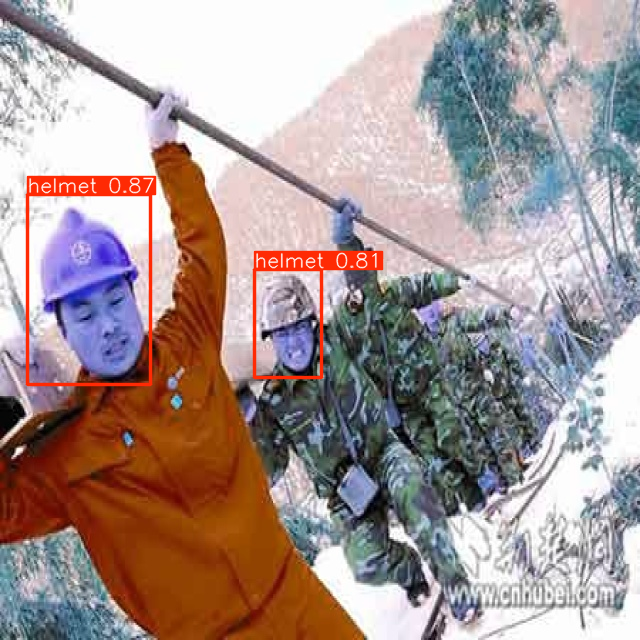

In [ ]:
# show prediction on image
r1 = model.predict(source='/content/dataset/test/images/000390.jpg')
Image.fromarray(r1[0].plot())



image 1/1 /content/dataset/test/images/pos_150.jpg: 640x640 1 vest, 7.1ms
Speed: 1.7ms preprocess, 7.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/dataset/test/images/bPartB_01128.jpg: 640x640 10 heads, 7.1ms
Speed: 2.0ms preprocess, 7.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/dataset/test/images/bPartB_00964.jpg: 640x640 25 heads, 7.1ms
Speed: 2.4ms preprocess, 7.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/dataset/test/images/000601.jpg: 640x640 1 helmet, 1 vest, 7.1ms
Speed: 2.0ms preprocess, 7.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/dataset/test/images/a01807.jpg: 640x640 3 helmets, 7.1ms
Speed: 2.0ms preprocess, 7.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


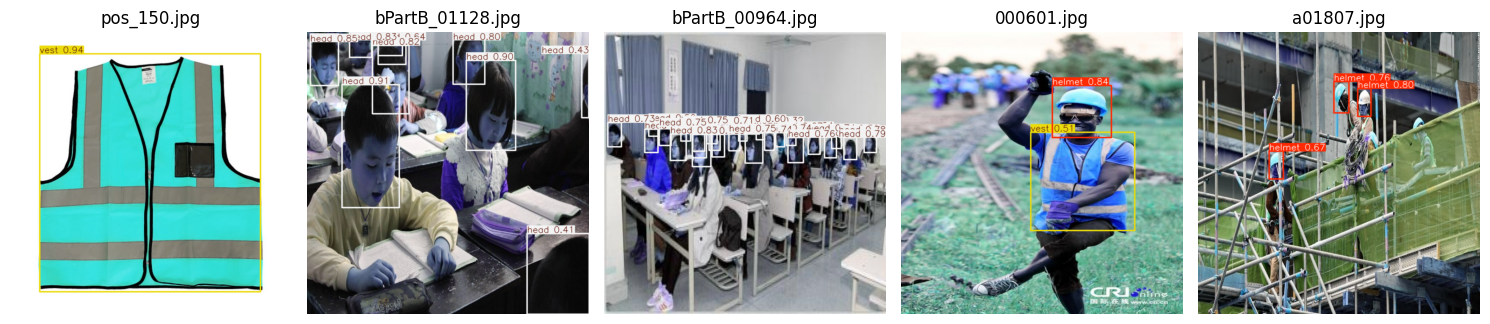

In [ ]:
# show prediction on image
test_image_folder = '/content/dataset/test/images/'

# Initialize an empty list for the test images
test_images = []

# Loop through files in the test image folder
for img in os.listdir(test_image_folder):
    if img.endswith('.jpg'):
        test_images.append(img)  # Add the image to the list


test_images = test_images[:5]

# Create a figure for displaying images and predictions
plt.figure(figsize=(15, 10))

for i, image_name in enumerate(test_images):
    img_path = os.path.join(test_image_folder, image_name)  # Full path of the image

    # Predict on the image
    r1 = model.predict(source=img_path)

    # Access the image data from the result object
    img = r1[0].plot()  # Assuming r1[0] is the first Result object

    # Display the image with predictions
    plt.subplot(1, 5, i + 1)
    plt.imshow(img)
    plt.title(image_name)
    plt.axis('off')

plt.tight_layout()
plt.show()

**Save files**

In [ ]:
# Path to the predictions folder and the output zip file
predictions = '/content/runs/detect/image_predictions'
output_zip = '/content/my_predictions.zip'

# Zip the folder using shutil
shutil.make_archive('/content/my_predictions', 'zip', predictions)



'/content/my_predictions.zip'